# Homework 1: Numpy, Scipy, Pandas

### Due Tues Feb 1, 2022 @ 8pm


## #0: Get set up with your environment to work on and submit homework

a. Create a new homework repository at github

<img src="data/screenshot_1.png">

Name your repo something sensible (e.g., python-ay250-homeworks). Given your Berkeley affiliation you should be able to get private repos if you'd like.

<img src="data/screenshot_2.png">


b. Clone this repo locally and make a directory for this week's homework:

```bash
cd /class/directories ## this will be different on your machine...whereever you want to keep your work.

# change <username> to your github username:
git clone https://github.com/<username>/python-ay250-homework.git
cd python-ay250-homework
mkdir hw_1
echo "hw_1 README" >> hw_1/README.md
git add hw_1/README.md
git commit hw_1/README.md -m "added hw_1 directory"
git push
```

c. Copy this notebook into your `hw_1` folder from a local version of the python-seminar repo

```bash
cd /class/directories
git clone https://github.com/profjsb/python-seminar.git 
cd python-seminar
git pull
cp -r Homeworks/hw_1/* /class/directories/python-ay250-homework/hw_1/
```

d. Get working! Be sure to check in your work as often as you'd like

```bash
cd /class/directories/python-ay250-homework
git add hw_1/<whatever>
git commit <whatever> -m "this is a check in"
git push
```

e. To submit your work, go to this form to register your homework Repo URL (https://forms.gle/z9XZqCD5Ra9ikTGQ8). If you've made your repo private, you'll need to add us as collaborators to the repo.  Our Github handles are `@profjsb` and `@elliesch`.

## #1:  Super-resolution imaging 

Obtaining several snapshots of the same scene, from microscopes to telescopes, is useful for the postprocessing increase of signal to noise: by summing up imaging data we can effectively beat down the noise. Interestingly, if we image the same scene from different vistas we can also improve the clarity of the combined image. Being able to discern features in a scene from this combination effort is sometimes called super-resolution imaging.

Here, we'll combine about 4 seconds of a shaky video to reveal the statement on a license plate that is not discernable in any one frame.

<img src="data/im2-1.png">

A tarball of the data is at: https://zenodo.org/record/5889322/files/homework1_data.tgz?download=1 (Zenodo page for the course: https://zenodo.org/record/5889322). This file is also in the read-only directory on `astro.datahub.berkeley.edu`.

```bash
tar -xvzf homework1_data.tgz  # do NOT check this files into git...
```

**Problem 1** Read in each image into a `numpy` array. Resize each frame to be 3 times larger in each axis (ie. 9 times larger images). Using `scipy.signal.fftconvolve` find the offsets of each frame with respect to the first frame. Report those offsets to 2 decimal places. 

   - Hint0: you can use `PIL` to read the images or `matplotlib.pyplot.imread`
```python
from PIL import Image
array = Image.open(fname).convert('L')
```
   - Hint1: you'll need to figure out how to resize a numpy array. Check out PIL.Image.resize...
   - Hint2: you'll want to reverse the second image when doing the convolution: `scipy.signal.fftconvolve(im1, im2[::-1, ::-1])`
   - Hint3: you'll need to figure out how to identify the peak of the fft convolution to find the offsets between images

In [1]:
# get file names
import glob
fnames = glob.glob('data/large_files/im2*.png')

nfiles = len(fnames)

In [2]:
# get index of base image (im2-0) and remaining images
base_idx = [i for i in range(nfiles) if 'im2-0' in fnames[i]][0]
remaining_idx = [i for i in range(nfiles) if i!=base_idx]

In [3]:
# load x3 image
from PIL import Image
import numpy as np

def load_x3_image(filename):
    """
    Takes as input a string (path to image file). 
    Loads image. Expands x3. 
    
    Paramters
    ----------
    filename: str
        path to image file  
    
    Returns
    -------
    data: np array
        clean image as 2D numpy array
        
    """
    
    # TODO: check that filename (1) exists & (2) is image file
    
    # load image 
    img = Image.open(filename).convert('L')
    
    # resize
    img_dims = np.array(img.size)
    img_x3 = img.resize(3*img_dims)

    # spit out image as np array
    return np.array(img_x3)

In [4]:
# read in base image
base_img = load_x3_image(fnames[base_idx])

# get size of base image
nrows,ncols = base_img.shape


In [5]:
# init data frame to store remaining images
raw_imgs = np.empty((nrows,ncols,nfiles-1))

# load remaining images
for f in range(nfiles-1):
    raw_imgs[:,:,f] = load_x3_image(fnames[remaining_idx[f]])

In [6]:
# sanity check: show base image & average of remaining raw images
%matplotlib inline
import matplotlib.pylab as plt

# plt.figure(figsize=(3,3))
# plt.imshow(base_img, cmap='gray')

# plt.figure(figsize=(3,3))
# plt.imshow(raw_imgs.mean(axis=2), cmap='gray')

In [7]:
# trim white borders (top & bottom) and mean center all images
def prepare_image(data):
    """
    Takes as input a np array (2D or 3D). 
    Find white borders from average column & remove.
    Mean center each image (assume images stacked in axis=2)
    
    Paramters
    ----------
    data: np array
        2D or 3D array; assume images are stacked along axis=2
        
    Returns
    -------
    data_pretty: np array
        2D or 3D, depending on input
        
    """
    
    # TODO: check data is 2D or 3D numpy array
    
    # get number of dimensions in 'data'
    dims = data.shape
    
    # find slice that excludes white borders, using average column
    avg_col = np.reshape(data,(dims[0],-1)).mean(axis=1)   
    keep_slice = avg_col != 255
    
    # remove white borders
    data_trimmed = data[keep_slice]

    # mean center each image
    newrows = data_trimmed.shape[0]
    
    m = data_trimmed.mean(axis=(0,1))
    if len(m.shape)>0: #3D array
        m_cube = np.tile(m.reshape((1,1,dims[2])),(newrows,dims[1],1))
    
    else: #2D array
        m_cube = np.tile(m,(newrows,dims[1]))
    
    data_pretty = data_trimmed - m_cube
    
    # return clean array
    return data_pretty

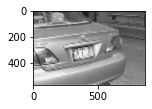

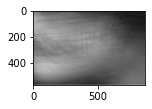

In [8]:
# prepare base and remaining images for convolution
base_img_clean = prepare_image(base_img)
raw_imgs_clean = prepare_image(raw_imgs)

# sanity check: show clean images
plt.figure(figsize=(2,2))
plt.imshow(base_img_clean, cmap='gray')

plt.figure(figsize=(2,2))
plt.imshow(raw_imgs_clean.mean(axis=2), cmap='gray')

In [57]:
# find all offsets from base image
# TODO: this is prety slow, maybe can speed up?

import scipy as sp
from numpy import unravel_index

def compute_offsets(base, raw):
    """
    Takes as input base 2D np array and subsequent raw 3D np array. 
    Convolve each image in raw (along axis=2) with base to find offset.
    Return offset to 2 decimal points.
    
    Paramters
    ----------
    base: np array
        2D array; mean centered
        
    raw: np array
        3D array; mean centered; assume images are stacked along axis=2
        
    Returns
    -------
    shift: np array
        2D array of tuples with row & col offsets
        
    """
    
    # TODO: check base is 2D and raw is 3D numpy array
    
    # get dimensions of raw
    nrows, ncols, nimgs = raw.shape
    
    # init array for tuples with row & col offsets
    shift = np.zeros((nimgs,2))
    
    # convolve each image with base
    for f in range(nimgs):
        fft = sp.signal.fftconvolve(base, raw[::-1,::-1,f], mode='full')
        fft_peak = unravel_index(fft.argmax(), fft.shape)
        shift[f,:] = np.array(fft_peak) - np.array([nrows, ncols])
        
    return shift
        
        

In [58]:
# compute offsets 
offsets = compute_offsets(base_img_clean, raw_imgs_clean)


In [60]:
# display offsets (in units of original pixels, rounded to 2 decimal places)
fnames_short = [f.replace('data/large_files/','').replace('.png','') for f in fnames]

for f in range(nfiles-1):
    print(f"offset between base im2-0 & {fnames_short[remaining_idx[f]]}: {np.round(offsets[f,:]/3,2)}")

offset between base im2-0 & im2-10: [34.33 -3.  ]
offset between base im2-0 & im2-9: [ -0.33 -27.  ]
offset between base im2-0 & im2-8: [ 21.33 -12.33]
offset between base im2-0 & im2-7: [ -0.33 -40.67]
offset between base im2-0 & im2-6: [44.33 23.67]
offset between base im2-0 & im2-5: [ 2.   10.67]
offset between base im2-0 & im2-4: [-0.33  0.  ]
offset between base im2-0 & im2-99: [30.67 -2.33]
offset between base im2-0 & im2-98: [48. 15.]
offset between base im2-0 & im2-97: [5. 5.]
offset between base im2-0 & im2-96: [34.67 -6.67]
offset between base im2-0 & im2-95: [ -0.33 -18.67]
offset between base im2-0 & im2-94: [39.67 15.33]
offset between base im2-0 & im2-93: [ 26.33 -51.67]
offset between base im2-0 & im2-92: [37.33 18.33]
offset between base im2-0 & im2-91: [29.33  3.33]
offset between base im2-0 & im2-90: [61.67 29.67]
offset between base im2-0 & im2-89: [  4.67 -18.67]
offset between base im2-0 & im2-88: [21.33 29.67]
offset between base im2-0 & im2-87: [62.67 -5.67]
offs

**Problem 2** Shift each image to register the frames to the original (expanded in size) frame. You should, in general, be shifting by subpixel offsets. You might want to look at `scipy.ndimage.interpolation.shift`

In [65]:
# init np array for shifted images
raw_imgs_corrected = np.empty(raw_imgs.shape)

for f in range(nfiles-1):
    output = sp.ndimage.interpolation.shift(raw_imgs[:,:,f],offsets[f])
    raw_imgs_corrected[:,:,f] = output
    
    

**Problem 3** Combine all the registered images to form a super-resolution image. What does the license plate read?

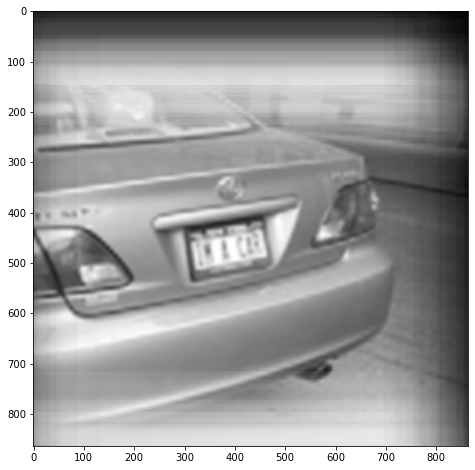

In [70]:
plt.figure(figsize=(8,8))
plt.imshow(raw_imgs_corrected.mean(axis=2),cmap='gray')

**IM A CAR**

# #2: An elementary introduction to spectral audio compression

In this problem, we'll explore the very basics of audio compression in the spectral domain using numpy and scipy. We'll do a bit of visualization with matplotlib, but since that is covered later in the course, we'll provide those functions for you.

Audio compression is a large and complex topic, and the design of a format for compressed audio such as the popular [MP3](http://en.wikipedia.org/wiki/MP3) is too complex to cover in detail here. However, we will introduce the basic tools that most such compression formats use, namely:

1. Converting the input signal to the frequency domain by taking a Fast Fourier Transform (FFT).

2. Dropping information in the frequency domain, resulting in a smaller amount of data.

3. Reconstructing back the signal in the time domain from this smaller representation of the signal.

Steps 1 and 2 above are the 'encoding' part of signal compression, and step 3 is the 'decoding' part. For this reason, the tools that perform these steps are typically referred to as signal 'codecs', short for encoders/decoders.

Note that here we say 'signal': while MP3 is an audio format, the same ideas apply to the compression of digital images with formats such as JPEG and video.  Virtually all multimedia technologies we use today, from audio players to cell phones, digital cameras and YouTubeVideo, are based on sophisticated extensions and applications of these simple ideas.

Let's first load the plotting tools and importing some tools we'll need later:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# we'll need some path manipulations later on
import os

We define a simple utility function to listen to audio files right in the browser:

In [2]:
def Audio(fname):
    """Provide a player widget for an audio file.
    
    Parameters
    ==========
    fname : string
      Filename to be played.
      
    Warning
    =======
    
    Browsers cache audio very aggressively. If you change an
    audio file on disk and are trying to listen to the  new version, you 
    may want to 
    """
    from IPython.display import HTML, display
    
    # Find out file extension and deduce MIME type for audio format
    ext = os.path.splitext(fname)[1].replace('.', '').lower()
    mimetype = 'audio/' + ('mpeg' if ext == 'mp3' else ext)
    
    tpl = """<p>{fname}:</p>
<audio controls>
    <source src="files/{fname}" type="{mimetype}">

Your browser does not support the Audio element; you can play 
<a href="files/{fname}">this file</a> manually.
</audio>
"""
    display(HTML(tpl.format(**locals())))

We also define a convenience wrapper around `plt.specgram`, [matplotlib's spectrogram function](http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.specgram), with a colorbar and control over the color limits displayed. This will make it easier to compare across different signals with the same colors for all inputs.

In [3]:
def specgram_cbar(x, title=None, clim=(0, 80) ):
    """Plot spectrogram with a colorbar and range normalization.
    
    Call matplotlib's specgram function, with a custom figure size, 
    automatic colobar, title and custom color limits to ease 
    comparison across multiple figures.
    
    Parameters
    ==========
    x : array
      One-dimensional array whose spectrogram should be plotted.
      
    title : string
      Optional title for the figure.
      
    clim : 2-tuple
      Range for the color limits plotted in the spectrogram.
    """
    f = plt.figure(figsize=(10,3))
    plt.specgram(x, Fs=2)
    plt.colorbar()
    plt.clim(*clim)
    if title is not None:
        plt.title(title)
    plt.show()

**Problem 1**: Use the `Audio` function above to listen to the signal we will be experimenting with, a simple voice recording stored in the file `Homeworks/hw1/data/voice.wav`.

Note: if your browser doesn't support audio, you may try a different browser.   We've tested current versions of Chrome and Firefox, and it works OK with both.

In [4]:
fname = 'data/voice.wav'
Audio(fname)

**Problem 2**: Write a function to compress a 1-d signal by dropping a fraction of its spectrum. 

You can drop the smallest components by setting their values to zero.

*Hints*: 

- look at the `np.fft` module, keeping in mind that your input signal is real.
- look at the `argsort` method of numpy arrays.

In [17]:
def compress_signal(x, fraction):
    """Compress an input signal by dropping a fraction of its spectrum.
    
    Parameters
    ==========
    x : array
      1-d real array to be compressed
      
    fraction : float
      A number in the [0,1] range indicating which fraction of the spectrum
      of x should be zeroed out (1 means zero out the entire signal).
      
    Returns
    =======
    x_approx : array
      1-d real array reconstructed after having compressed the input.
    """
    
    # TODO: check if x is real array?
    
    # fft of x
    compressed = np.fft.fft(x)
    
    # get corresponding freq
    freq = np.fft.fftfreq(x.shape[0])
    
    # set low freq = 0, according to fraction input
    set_to_zero = abs(freq) > (0.5 - fraction/2)
    compressed[set_to_zero] = 0
    
    # reconstruct signal
    reconstructed = np.fft.ifft(compressed)
    
    # return real component of reconstructed signal
    return reconstructed.real


As a quick visual check (not that this is *not* a formal test of correctness), experiment with a simple random signal by changing the compression ratio and plotting both the signal and the compressed version:

In [18]:
x = np.random.rand(128)

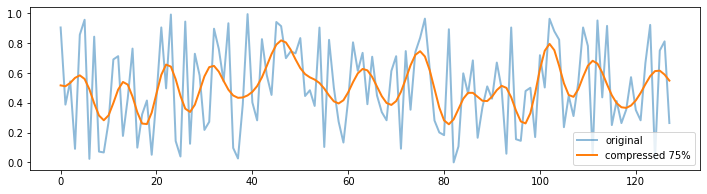

In [19]:
fraction = .75 # play changing this in the 0-1 range

xa = compress_signal(x, fraction)

plt.figure(figsize=(12,3))
plt.plot(x, alpha=0.5, lw=2, label='original')
plt.plot(xa, lw=2, label='compressed {0:.0%}'.format(fraction))
plt.legend();

**Problem 3**: Write a function that will compress an audio file by a dropping a fraction of its spectrum, writing the output to a new file.

If the input file is named `a.wav` and the compression fraction is 0.9, the output file should be named `a_comp_0.9.wav`.

*Hints:* 

- look at the `scipy.io` module for routines dealing with files in `wav` format.

- you may need to use the `astype` method of numpy arrays to get the correct data type for `wav` files.

In [22]:
from scipy.io import wavfile

def compress_wav(fname, fraction):
    """Compress an audio signal stored in an input wav file.
    
    The compressed signal is returned as a numpy array and automatically written 
    to disk to a new wav file.
    
    Parameters
    ==========
    fname : string
      Name of the input wav file
      
    fraction : float
      Fraction of input data to keep.
      
    Returns
    =======
    rate : int
      Bit rate of the input signal.

    x : array
      Raw data of the original input signal.
      
    x_approx : array
      Raw data of the compressed signal.
      
    new_fname : string
      Auto-generated filename of the compressed signal.
    """
    
    # load fname wave file
    rate, x = wavfile.read(fname)
    
    # compress by dropping low freq according to fraction
    x_approx = compress_signal(x, fraction)
    
    # generate new filename
    new_fname = fname.replace('.wav', f"_comp_{fraction}.wav")
    
    # save new wav file
    wavfile.write(new_fname, rate, x_approx.astype(np.int16))
    
    # return expected vars
    return rate, x, x_approx, new_fname

**Problem 4**: Study the effect of compressing the input file at different ratios: 0.1, 0.5, 0.75, 0.9, 0.95, 0.99.

Using the `OrderedDict` class from the [Python collections module](https://docs.python.org/3/library/collections.html#collections.OrderedDict), store the uncompressed signal as well as the compressed array and filename for each compression ratio.

You will create an `OrderedDict` called `voices`, with:

- keys: compression ratios
- values: pairs of (x, filename) where x is the compressed audio and filename is the name of the compressed file.

In [23]:
# compression ratios; storing uncompressed signal as first element
compress_ratios = [0, 0.1, 0.5, 0.75, 0.9, 0.95, 0.99]

# make OrderedDict
from collections import OrderedDict 
voices = OrderedDict()

# make compressed files and add info to voices
for c in compress_ratios:
    rate, x, x_approx, new_fname = compress_wav(fname, c)
    voices[c] = (x_approx, new_fname)

**Problem 5**: Loop over the `voices` dict, and for each one generate an audio player as well as a spectrogram.  Observe how the spectrogram changes, and listen to each file.  At what ratio do you stop understanding the recording?

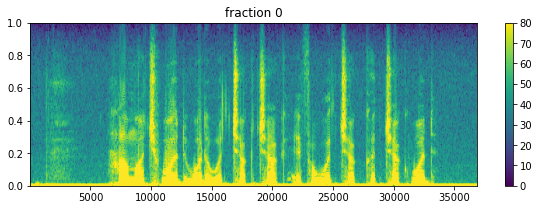

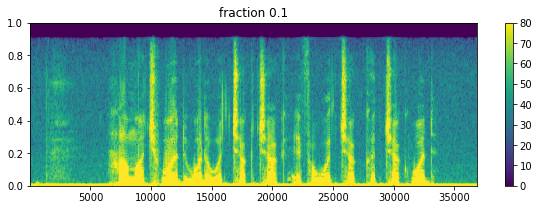

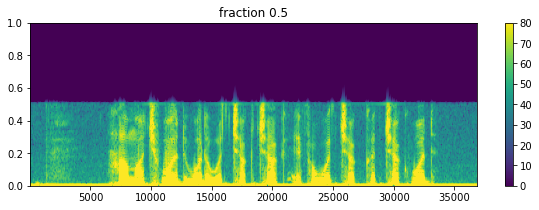

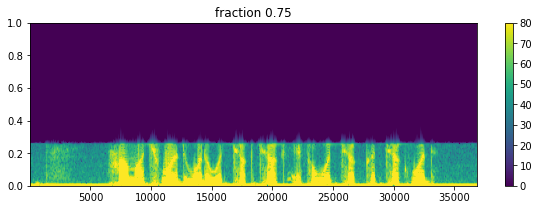

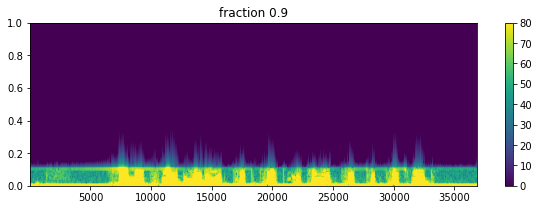

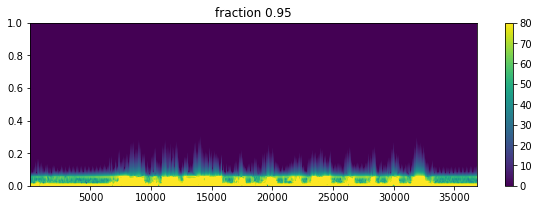

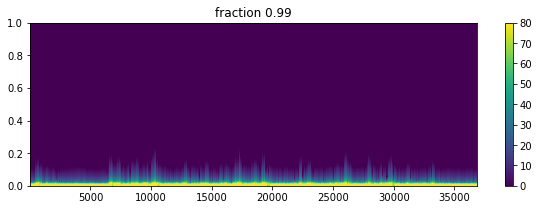

In [24]:
for key, value in voices.items():
    # make audio player 
    Audio(value[1])
    
    # make spectrogram
    specgram_cbar(value[0], title=f"fraction {key}", clim=(0, 80) )

**The compressed audio files are difficult to understand if the compression fraction exceeds 0.9.**

# #3: Armchair Astronomer

Often times, people act as good sensors of the physical universe. We can use Google Trends data to help us determine some fundamental parameters of the Solar System.

**Problem 1**: Using just the CSV file we created in the pandas lecture (`merged_data.csv`) and some frequency analysis tools in `scipy` to determine:

   - the number of days in a year
   - the period of the moon's orbit around the Earth
   
Hint: `from scipy.signal.spectral import lombscargle` (you'll want to normalize your signal so it has a mean of zero.)

**All cells below are junk, ignore**

In [1]:
import numpy as np
import pandas as pd

In [95]:
# load data
df = pd.read_csv('data/merged_data.csv')

# add combined tennis & ice cream term (rescale for visualization)
df['tennis * ice cream'] = df['tennis'] * df['ice cream']/10

<AxesSubplot:xlabel='weeks', ylabel='search frequency'>

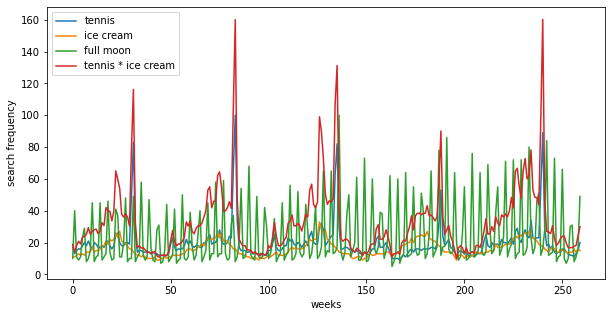

In [96]:
# visualize data
%matplotlib inline
import matplotlib.pyplot as plt

df.plot(xlabel='weeks',ylabel='search frequency',figsize=(10,5))

In [97]:
# convert weeks to datetime
from datetime import datetime
import dateutil.parser as parser

df['Week'] = pd.to_datetime(df['Week'])
df.set_index('Week', inplace=True)

In [100]:
# resample df to make daily 
df_daily = df.resample('D').nearest()

# # sanity check: show resampled data
# df_daily.plot(xlabel='time (years)',ylabel='search frequency',figsize=(10,5))

In [166]:
from scipy.signal.spectral import lombscargle

def compute_period(df_daily, term, days_min, days_max):
    """
    Takes as input dataframe (assuming resampled to daily data points). 
    Find the period for the indicated term in specified range.
    
    Paramters
    ----------
    df_daily: pd data frame
        assume daily samples
        
    term: str
        term to use for period calculation
    
    days_min: int
        low end for possible period range
        
    days_max: int
        high end for possible period range
        
    Returns
    -------
    period: float
        peak period in range
        
    """
    
    # TODO: check all inputs are what I assume they are, and 
    #'term' exists in 'df_daily'
    
    # set periods to check
    possible_periods = np.linspace(days_min, days_max, 1000)
    
    # convert to frequencies (in radians)
    possible_freqs = 2 * np.pi / possible_periods
    
    # count number of days from first day
    sample_day = np.arange(1,1+df_daily.shape[0])
    
    # calculate periodigram
    periodigram = lombscargle(sample_day, # sample times
                             df_daily[term], # measurement values
                             possible_freqs) # angular frequencies
    
    # get peak of periodigram
    peak_period = np.argmax(periodigram)
    
    # sanity check: plot periodigram
    plt.plot(possible_periods, periodigram)
    plt.xlabel('period (days)')
    plt.ylabel('power (?)') # need to look up correct units...
    plt.scatter(possible_periods[peak_period], periodigram[peak_period], c='red')
    
    # spit out peak period
    return np.round(possible_periods[peak_period],2)

period of moon's orbit: 29.53 days


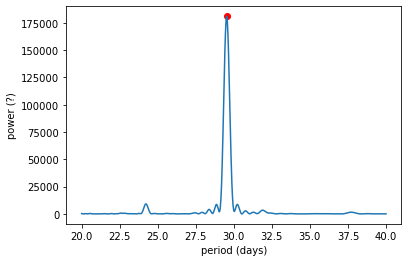

In [167]:
moon_period = compute_period(df_daily, 'full moon', 20, 40)
print(f"period of moon's orbit: {moon_period} days")

year, from tennis: 385.39 days


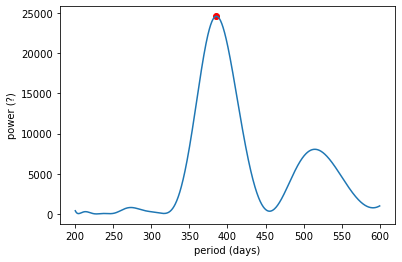

In [168]:
tennis_period = compute_period(df_daily, 'tennis', 200, 600)
print(f"year, from tennis: {tennis_period} days")

year, from ice cream: 385.39 days


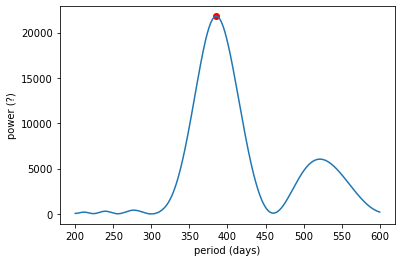

In [169]:
icecream_period = compute_period(df_daily, 'ice cream', 200, 600)
print(f"year, from ice cream: {icecream_period} days")

year, from tennis * ice cream: 378.98 days


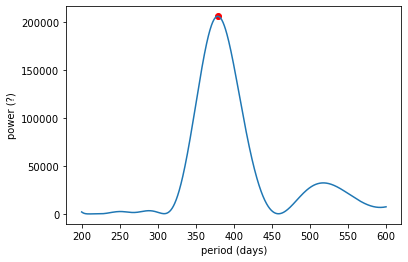

In [170]:
tennisice_period = compute_period(df_daily, 'tennis * ice cream', 200, 600)
print(f"year, from tennis * ice cream: {tennisice_period} days")

**the number of days in a year:**
from moon: 29.53 days

**the period of the moon's orbit around the Earth:**
best from tennis * ice cream: 378.98 days